##Import Libraries

In [ ]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

## Keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

##Reading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Directory

dir_list = os.listdir('/content/drive/MyDrive/Voice Stress detection/Speech_dataset')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
# Create DataFrame for Data intel
data_frame = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('/content/drive/MyDrive/Voice Stress detection/Speech_dataset/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = '/content/drive/MyDrive/Voice Stress detection/Speech_dataset/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_frame.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [ ]:
print (len(data_frame))
data_frame.head(25)

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,1
1,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,1,1
2,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,0,1
3,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,1,2
4,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,0,2
5,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,1,1
6,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,2
7,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,1,0,0,2
8,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,1,2
9,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,3


##Plotting the audio files wave and its spectogram

In [ ]:
filename = data_frame.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/content/drive/MyDrive/Voice Stress detection/Speech_dataset/Actor_18/03-01-02-01-02-01-18.wav


(22050, array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         4.6953952e-09, -3.3706307e-09,  0.0000000e+00], dtype=float32))

In [ ]:
len(samples), sample_rate

(80196, 22050)

In [ ]:
def log_specogram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
sample_rate/ len(samples)

0.2749513691455933

Text(0.5, 0, 'Seconds')

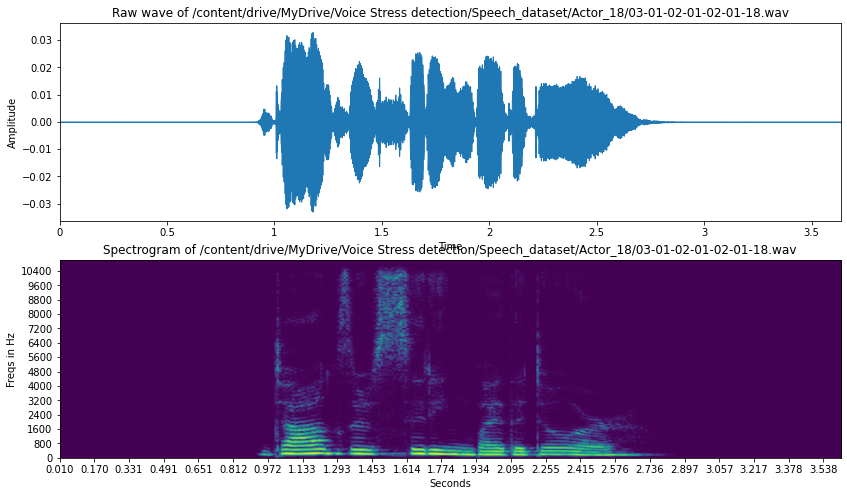

In [ ]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specogram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [ ]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-4.5053457e-05, -4.6858717e-05, -4.3048098e-05, ...,
        -5.1633379e-04, -4.8599389e-04, -4.8891839e-04], dtype=float32),
 array([19968, 60416]))

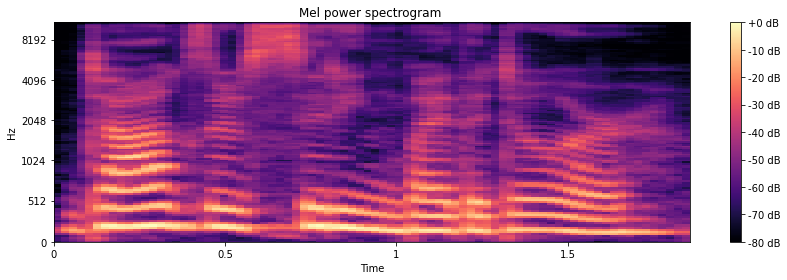

In [ ]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

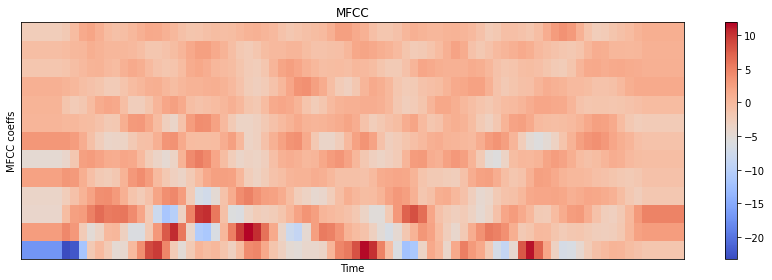

In [ ]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [ ]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by manual trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

##Defining the labels for emotion

In [ ]:
# class: Not Stressed & Stressed

# Not Stressed: Calm, Happy
# Stressed: Angry, Fearful, Sad

label1_list = []
for i in range(len(data_frame)):
    if data_frame.emotion[i] == 2: # Calm
        lb = "_not_stressed"
    elif data_frame.emotion[i] == 3: # Happy
        lb = "_not_stressed"
    elif data_frame.emotion[i] == 4: # Sad
        lb = "_stressed"
    elif data_frame.emotion[i] == 5: # Angry
        lb = "_stressed"
    elif data_frame.emotion[i] == 6: # Fearful
        lb = "_stressed"
    elif data_frame.emotion[i] == 7: # Disgust
        lb = "_not_stressed"
    elif data_frame.emotion[i] == 8: # Surprised
        lb = "_not_stressed"        
    else:
        lb = "_neutral"
        
    # Add gender to the label    
    label1_list.append(data_frame.gender[i] + lb)
    
len(label1_list)

1440

In [ ]:
data_frame['label'] = label1_list
data_frame.head(25)

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,1,male_neutral
1,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,1,1,male_neutral
2,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,0,1,male_neutral
3,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,1,2,male_not_stressed
4,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,0,2,male_not_stressed
5,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,1,1,male_neutral
6,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,2,male_not_stressed
7,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,1,0,0,2,male_not_stressed
8,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,1,2,male_not_stressed
9,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,3,male_not_stressed


In [ ]:
print (data_frame.label.value_counts().keys())

Index(['male_not_stressed', 'female_not_stressed', 'male_stressed',
       'female_stressed', 'male_neutral', 'female_neutral'],
      dtype='object')


In [ ]:
# Plotting the emotion distribution

def plot_emotion_distri(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

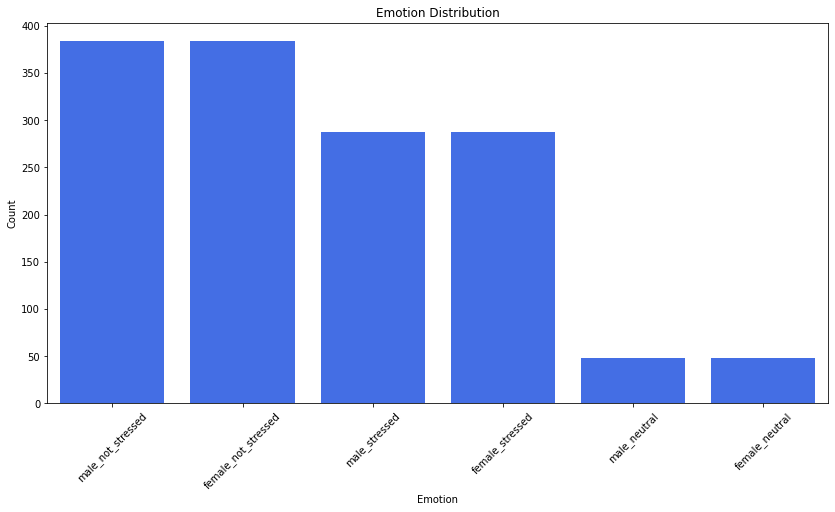

In [ ]:
a = data_frame.label.value_counts()
plot_emotion_distri(a, "#2962FF", "Emotion Distribution")

##Data Splitting

In [ ]:

data1_df = data_frame.copy()


tmp1 = data1_df[data1_df.actor == 21]
tmp2 = data1_df[data1_df.actor == 22]
tmp3 = data1_df[data1_df.actor == 23]
tmp4 = data1_df[data1_df.actor == 24]
data2_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data1_df = data1_df[data1_df.actor != 21]
data1_df = data1_df[data1_df.actor != 22]
data1_df = data1_df[data1_df.actor != 23].reset_index(drop=True)
data1_df = data1_df[data1_df.actor != 24].reset_index(drop=True)

print (len(data1_df))
data1_df.head(50)

1200


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,1,male_neutral
1,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,1,1,male_neutral
2,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,0,1,male_neutral
3,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,1,2,male_not_stressed
4,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,0,2,male_not_stressed
5,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,1,1,male_neutral
6,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,2,male_not_stressed
7,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,1,0,0,2,male_not_stressed
8,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,1,1,2,male_not_stressed
9,/content/drive/MyDrive/Voice Stress detection/...,1,1,male,0,0,0,3,male_not_stressed


In [ ]:
print (len(data2_df))
data2_df.head(80)

120


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/drive/MyDrive/Voice Stress detection/...,1,21,male,0,0,1,2,male_not_stressed
1,/content/drive/MyDrive/Voice Stress detection/...,1,21,male,0,1,1,1,male_neutral
2,/content/drive/MyDrive/Voice Stress detection/...,1,21,male,0,0,0,1,male_neutral
3,/content/drive/MyDrive/Voice Stress detection/...,1,21,male,0,0,0,2,male_not_stressed
4,/content/drive/MyDrive/Voice Stress detection/...,1,21,male,0,1,0,1,male_neutral
...,...,...,...,...,...,...,...,...,...
75,/content/drive/MyDrive/Voice Stress detection/...,1,23,male,1,1,1,4,male_stressed
76,/content/drive/MyDrive/Voice Stress detection/...,1,23,male,1,0,0,5,male_stressed
77,/content/drive/MyDrive/Voice Stress detection/...,1,23,male,1,1,1,6,male_stressed
78,/content/drive/MyDrive/Voice Stress detection/...,1,23,male,1,0,0,2,male_not_stressed


## Analysing Features of audio files using librosa

In [ ]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data1_df))):
    X, sample_rate = librosa.load(data1_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 1200/1200 [11:14<00:00,  1.78it/s]


In [ ]:
data.head()

,feature
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-67.55739, -67.55739, -67.55739, -67.55739, -..."
4,"[-69.67329, -69.693306, -69.693306, -69.693306..."


In [ ]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data1_df.label

In [ ]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388
4,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306


In [ ]:
newdf = pd.concat([df3,labels], axis=1)

In [ ]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

1200

In [ ]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
1,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_not_stressed
4,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_not_stressed
5,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
6,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_not_stressed
7,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_not_stressed
8,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN,male_not_stressed
9,-63.311062,-63.072487,-63.412422,-63.796757,-63.581989,-58.921223,-57.955044,-61.224972,-63.782932,-63.796757,...,-63.740608,-62.410255,-62.489079,-62.494453,-62.632626,-62.824276,NaN,NaN,NaN,male_not_stressed


In [ ]:
rnewdf.isnull().sum().sum()

5104

In [ ]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_not_stressed
4,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_not_stressed


##Data Making/Processing

In [ ]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

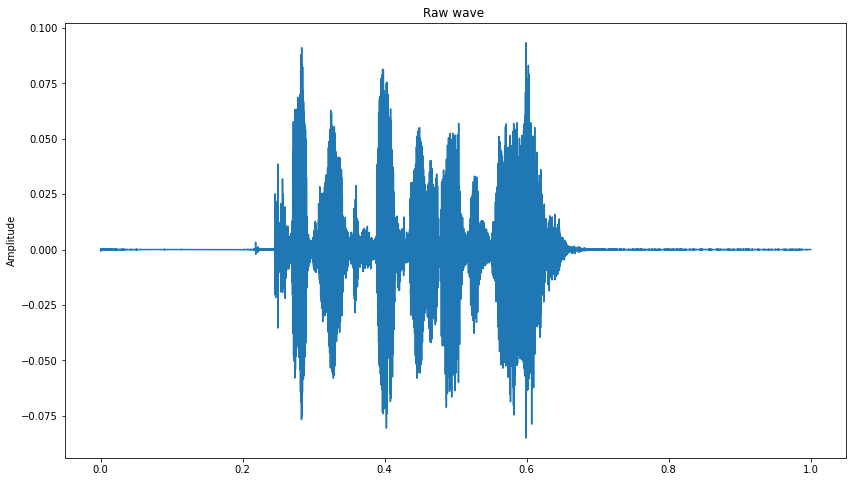

In [ ]:
X, sample_rate = librosa.load(data1_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.3)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

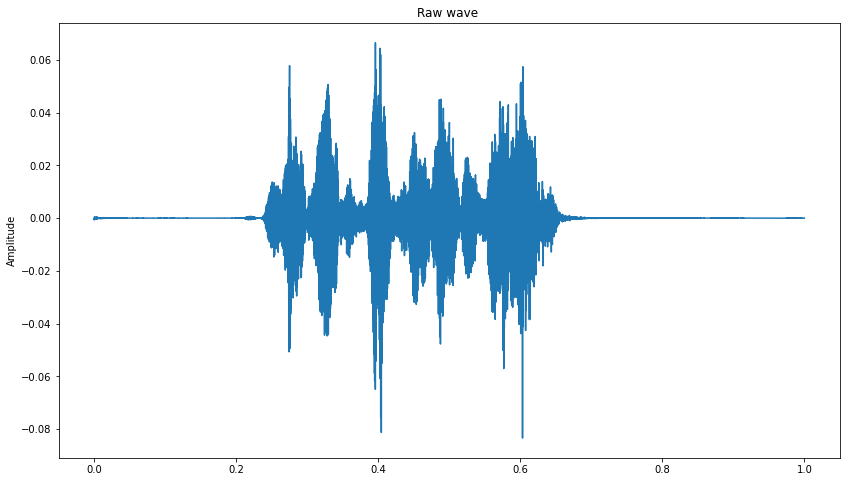

In [ ]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [ ]:
# Data Making Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data1_df))):
    X, sample_rate = librosa.load(data1_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data1_df.label[i]:
#     if data1_df.label[i] == "male_stressed":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data1_df.label[i]]

100%|██████████| 1200/1200 [02:01<00:00,  9.85it/s]


In [ ]:
syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data1_df))):
    X, sample_rate = librosa.load(data1_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data1_df.label[i]:
#     if data1_df.label[i] == "male_stressed":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data1_df.label[i]]

100%|██████████| 1200/1200 [06:19<00:00,  3.16it/s]


In [ ]:
len(syn_data1), len(syn_data2)

(1200, 1200)

In [ ]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [ ]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1200

In [ ]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-62.409010,-61.618995,-61.150445,-63.011348,-63.930355,-64.666751,-63.929972,-63.112418,-61.975367,-62.247920,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,male_neutral
1,-53.001652,-54.685587,-52.777412,-50.280700,-51.482343,-52.123412,-52.019714,-50.155367,-48.953339,-49.676770,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,male_neutral
2,-65.818894,-65.818894,-65.818894,-65.818894,-65.818894,-65.818894,-65.818894,-65.637122,-65.000230,-65.818894,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,male_neutral
3,-58.161281,-57.714475,-57.597262,-55.321190,-55.485724,-57.515769,-59.086660,-58.552403,-57.338071,-59.491554,...,-57.461545,-59.792708,-56.518741,-56.983752,-56.385421,-54.27065,-55.939293,-58.329362,-59.763857,male_not_stressed
4,-52.872263,-52.796784,-52.198482,-53.276569,-53.134378,-54.301426,-52.109741,-52.198680,-50.521478,-50.129723,...,-52.260428,-52.074456,-53.547048,-52.081143,-52.061040,-53.18359,-51.803337,-51.807272,-53.422910,male_not_stressed


In [ ]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1200

In [ ]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.355155,-70.355155,-70.355155,-70.355155,-70.355155,-70.355155,-70.355155,-70.355155,-70.355155,-70.355155,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-68.679444,-68.840642,-68.840642,-68.840642,-68.840642,-68.840642,-68.840642,-68.840642,-68.840642,-68.840642,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-66.800472,-66.800472,-66.800472,-66.800472,-66.800472,-66.800472,-66.800472,-66.800472,-66.800472,-66.800472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-71.054251,-71.011623,-70.852191,-71.054251,-71.054251,-70.019387,-68.454767,-70.573958,-71.054251,-71.054251,...,-71.054251,-71.054251,-71.054251,-71.054251,-71.054251,-71.054251,-71.054251,-71.054251,-70.623837,male_not_stressed
4,-71.011009,-71.390565,-71.545676,-71.545676,-71.545676,-71.545676,-71.545676,-71.545676,-71.434906,-70.821093,...,-71.545676,-71.545676,-71.545676,-71.545676,-71.236775,-71.545676,-71.545676,-71.545676,-71.545676,male_not_stressed


In [ ]:
# Combining the Proccessed data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_not_stressed
4,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_not_stressed


In [ ]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_train.value_counts()

female_not_stressed    768
male_not_stressed      768
male_stressed          576
female_stressed        576
female_neutral          96
male_neutral            96
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

male_not_stressed      192
female_not_stressed    192
female_stressed        144
male_stressed          144
female_neutral          24
male_neutral            24
Name: label, dtype: int64

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train

array([[-52.08925555, -50.98885069, -51.26375539, ..., -50.40523007,
        -51.306035  , -52.92962198],
       [-56.06360626, -56.11090469, -56.61036682, ..., -54.54955673,
        -56.03255844, -55.09996033],
       [-53.815137  , -55.66349298, -55.25875579, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-42.9615821 , -42.19262675, -42.61726425, ..., -40.71420656,
        -41.96910321, -42.62227184],
       [-55.64297705, -55.77993089, -55.0661773 , ..., -53.79227986,
        -55.95326685, -57.92483069],
       [-63.26338469, -62.76407436, -63.15169345, ..., -63.04154293,
        -62.03990888, -62.84238666]])

In [ ]:
X_train.shape

(2880, 259)

##Creating CNN Model

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='valid',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())

model.add(Dense(6))
model.add(Activation("softmax"))
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 252, 256)          2304      
                                                                 
 activation (Activation)     (None, 252, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 252, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 252, 256)          0         
                                                                 
 dropout (Dropout)           (None, 252, 256)          0         
                                                        

In [ ]:
# Compile your model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

mcp_save = ModelCheckpoint('/content/drive/MyDrive/Voice Stress detection/Predictions/Data_noiseNshift.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100
180/180 [==============================] - 94s 525ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.7639 - val_accuracy: 0.8319 - lr: 8.1000e-04
Epoch 2/100
180/180 [==============================] - 74s 410ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.7758 - val_accuracy: 0.8236 - lr: 8.1000e-04
Epoch 3/100
180/180 [==============================] - 73s 407ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.6510 - val_accuracy: 0.8583 - lr: 8.1000e-04
Epoch 4/100
180/180 [==============================] - 74s 408ms/step - loss: 0.0290 - accuracy: 0.9903 - val_loss: 1.2137 - val_accuracy: 0.7139 - lr: 8.1000e-04
Epoch 5/100
180/180 [==============================] - 74s 412ms/step - loss: 0.1092 - accuracy: 0.9615 - val_loss: 0.6079 - val_accuracy: 0.8347 - lr: 8.1000e-04
Epoch 6/100
180/180 [==============================] - 73s 404ms/step - loss: 0.0292 - accuracy: 0.9889 - val_loss: 1.6102 - val_accuracy: 0.6667 - lr: 8.1000e-04
Epoch 7/100
180/180 [=

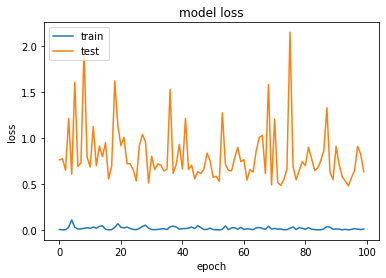

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model.json

import json
model_json = model.to_json()
with open("/content/drive/MyDrive/Voice Stress detection/Predictions/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Voice Stress detection/Predictions/Data_noiseNshift.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 88.61%


## Predicting emotions on the test data

In [ ]:
len(data1_df)

1200

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data1_df))):
    X, sample_rate = librosa.load(data1_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data1_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 1200/1200 [01:42<00:00, 11.66it/s]


In [91]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

75/75 [==============================] - 7s 90ms/step


In [92]:
preds

array([[           nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan],
       ...,
       [           nan,            nan,            nan,            nan,
                   nan,            nan],
       [2.86674822e-19, 1.98335272e-07, 9.99999762e-01, 1.76431771e-30,
        4.33972672e-15, 4.24937125e-12],
       [1.11869854e-10, 9.99996066e-01, 3.18819230e-06, 1.75599646e-10,
        2.42900768e-07, 4.90670686e-07]], dtype=float32)

In [93]:
preds1=preds.argmax(axis=1)

In [94]:
preds1

array([0, 0, 0, ..., 0, 2, 1])

In [95]:
abc = preds1.astype(int).flatten()

In [96]:
print(abc)


[0 0 0 ... 0 2 1]


In [97]:
predictions = (lb.inverse_transform((abc)))

In [98]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_neutral
1,female_neutral
2,female_neutral
3,male_not_stressed
4,male_not_stressed
5,female_neutral
6,male_not_stressed
7,male_not_stressed
8,male_not_stressed
9,male_not_stressed


In [99]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [100]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_neutral
1,male_neutral
2,male_neutral
3,male_not_stressed
4,male_not_stressed
5,male_neutral
6,male_not_stressed
7,male_not_stressed
8,male_not_stressed
9,male_not_stressed


In [101]:
finaldf = actualdf.join(preddf)

## Actual vs Predicted Values

In [102]:
finaldf[40:60]

,actualvalues,predictedvalues
40,male_stressed,male_stressed
41,male_stressed,male_stressed
42,male_not_stressed,male_not_stressed
43,male_not_stressed,female_neutral
44,male_stressed,male_stressed
45,male_stressed,male_stressed
46,male_stressed,male_stressed
47,male_not_stressed,male_not_stressed
48,male_stressed,male_stressed
49,male_not_stressed,male_not_stressed


In [103]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_neutral,40
female_not_stressed,320
female_stressed,240
male_neutral,40
male_not_stressed,320
male_stressed,240


In [104]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_neutral,268
female_not_stressed,291
female_stressed,217
male_neutral,17
male_not_stressed,230
male_stressed,177


In [105]:
finaldf.to_csv('/content/drive/MyDrive/Voice Stress detection/Predictions/Predictions.csv', index=False)

In [106]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [107]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

80.33333333333333

In [108]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

73.4713868831943

In [109]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[ 39,   0,   0,   0,   0,   1],
       [ 30, 289,   1,   0,   0,   0],
       [ 21,   2, 216,   0,   1,   0],
       [ 23,   0,   0,  17,   0,   0],
       [ 89,   0,   0,   0, 229,   2],
       [ 66,   0,   0,   0,   0, 174]])

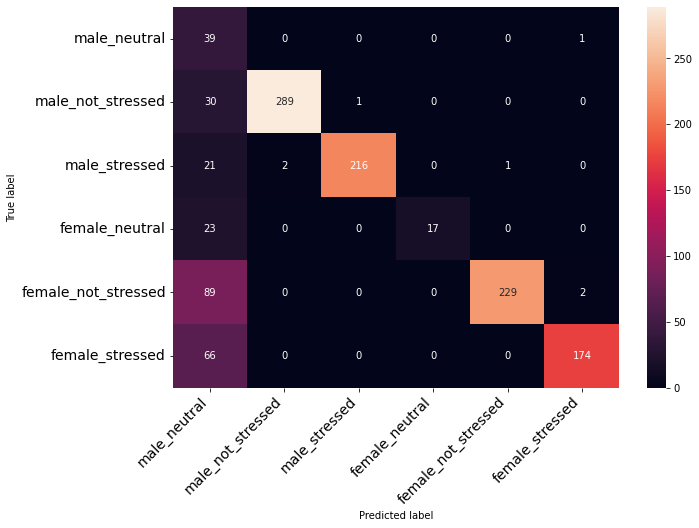

In [110]:
# Visualize Confusion Matrix 

class_names = ['male_neutral', 'male_not_stressed', 'male_stressed','female_neutral', 'female_not_stressed', 'female_stressed']

print_confusion_matrix(c, class_names)